Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Akurasi: 0.9008
Recall: 0.7881
F1-Score: 0.8774

Parameter terbaik:
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


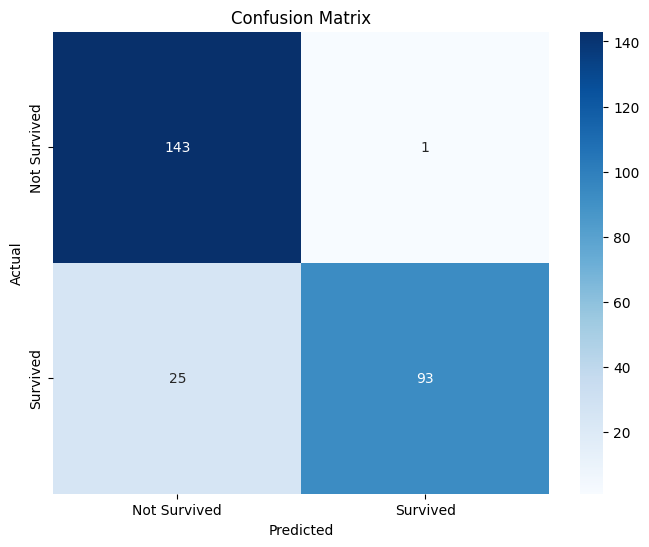

In [5]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Sembunyikan FutureWarning
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Buka dataset
data = pd.read_csv('titanic.csv')

# Managemen Fitur (Manipulasi Data)
data = data.copy()  # Create a copy to avoid SettingWithCopyWarning
data['Age'] = data['Age'].fillna(data['Age'].median())
data['Port of Embarkation'] = data['Port of Embarkation'].fillna(
    data['Port of Embarkation'].mode()[0])
data['Passenger Fare'] = data['Passenger Fare'].fillna(
    data['Passenger Fare'].median())
data = data.drop(['Cabin', 'Name', 'Ticket Number'], axis=1)
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})
data = pd.get_dummies(data, columns=['Port of Embarkation'])

# Penanganan 'Port of Embarkation' dan 'Passenger Class'
if 'Port of Embarkation' in data.columns:
    data['Port of Embarkation'] = data['Port of Embarkation'].fillna(
        data['Port of Embarkation'].mode()[0])
    data = pd.get_dummies(data, columns=['Port of Embarkation'])

if 'Passenger Class' in data.columns:
    data = pd.get_dummies(data, columns=['Passenger Class'])

# Pemisahan fitur dan target
x = data.drop('Survived', axis=1)
y = data['Survived']

# Convert all columns to numeric, replacing non-numeric values with NaN
x = x.apply(pd.to_numeric, errors='coerce')

# Fill NaN values with the mean of the respective column
x = x.fillna(x.mean())

# Normalize features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    x_scaled, y, test_size=0.2, random_state=42)

# Initialize and train RandomForestClassifier with GridSearchCV for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    verbose=2,
    scoring='accuracy',
    error_score='raise'
    )

# Latih model dengan GridSearchCV
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_


# Make predictions on test data
y_pred = best_model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, pos_label='Yes')
f1 = f1_score(y_test, y_pred, pos_label='Yes')
cm = confusion_matrix(y_test, y_pred)

print(f"Akurasi: {accuracy :.4f}")
print(f"Recall: {recall :.4f}")
print(f"F1-Score: {f1 :.4f}")

# Tampilkan parameter terbaik
print("\nParameter terbaik:")
print(grid_search.best_params_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()